In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [2]:
from torchvision import datasets

# VGG

<img src='images/miniVGG.png'>

In [3]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, pool=True, drop_rate=0.):
        super().__init__()
        # 模块：二维卷积
        self.add_module('conv', nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=True))
        # 模块：激活函数
        self.add_module('relu', nn.ReLU(inplace=True))
        # 模块：Normalization
        self.add_module('norm', nn.BatchNorm2d(out_channels))
        # 模块：池化层
        if pool:
            self.add_module('pool', nn.MaxPool2d(kernel_size=2))
        if drop_rate > 0:
            self.add_module('dropout', nn.Dropout(p=drop_rate)) 
    # 可写可不写：
    def forward(self, x):
        return super().forward(x)

In [4]:
# 验证
conv_block = ConvBlock(3,32)
print(conv_block)
x = torch.randn(5,3,32,32)
y = conv_block(x)
print(x.shape,y.shape)

ConvBlock(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([5, 3, 32, 32]) torch.Size([5, 32, 16, 16])


In [5]:
class FCBlock(nn.Sequential):
    def __init__(self, dim_in, dim_out, drop_rate=0.):
        super().__init__()
        self.add_module('fc', nn.Linear(dim_in, dim_out))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('norm', nn.BatchNorm1d(dim_out))
        if drop_rate > 0:
            self.add_module('dropout', nn.Dropout(p=drop_rate))
            
    def forward(self, x):
        return super().forward(x)

In [6]:
fc_block = FCBlock(400,5)
print(fc_block)
x = torch.randn(5,400)
y = fc_block(x)
print(x.shape,y.shape)

FCBlock(
  (fc): Linear(in_features=400, out_features=5, bias=True)
  (relu): ReLU(inplace=True)
  (norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([5, 400]) torch.Size([5, 5])


In [7]:
class MiniVGG(nn.Module):
    def __init__(self, drop_rate=0.):
        super().__init__()
        self.conv = nn.Sequential()
        self.conv.add_module('block1', ConvBlock(3,  32,
                                                 pool=False))
        self.conv.add_module('block2', ConvBlock(32, 32,
                                                 pool=True,  drop_rate=drop_rate))
        self.conv.add_module('block3', ConvBlock(32, 64,
                                                 pool=False))
        self.conv.add_module('block4', ConvBlock(64, 64,
                                                 pool=True, drop_rate=drop_rate))

        self.fc = nn.Sequential()
        self.fc.add_module('fc_block', FCBlock(4096, 512, drop_rate=drop_rate))
        self.fc.add_module('last_layer', nn.Linear(512, 10))

    @property
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params
            
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4096)
        out = self.fc(x)
        return out

    def forward_test(self, x):
        print(f"{'input':<15}: {str(x.data.shape):>20}")
        for name, module in self.conv._modules.items():
            x = module(x)
            print(f"{name:<15}: {str(x.data.shape):>20}")
        x = x.view(-1, 4096)
        for name, module in self.fc._modules.items():
            x = module(x)
            print(f"{name:<15}: {str(x.data.shape):>20}")


In [8]:
vgg = MiniVGG()
print(vgg.model_size)
print(f'{vgg.model_size * 4 / 1024**2} MB')

2169770
8.277015686035156 MB


In [9]:
x = torch.randn(5, 3, 32, 32)
y = vgg.forward_test(x)

input          : torch.Size([5, 3, 32, 32])
block1         : torch.Size([5, 32, 32, 32])
block2         : torch.Size([5, 32, 16, 16])
block3         : torch.Size([5, 64, 16, 16])
block4         : torch.Size([5, 64, 8, 8])
fc_block       : torch.Size([5, 512])
last_layer     :  torch.Size([5, 10])


# ResNet

<img src='images/resnet18.png'>

<img src='images/resblock.png'>

In [10]:
import torch.nn.functional as F

In [11]:
class ResidualBlock(nn.Module):
    """ResidualBlock"""
    expansion = 1
    def __init__(self, in_channel, out_channel, stride=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channel),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channel))
        self.shortcut = nn.Sequential()
        if in_channel != out_channel:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channel))
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv(x)        
        out += identity
        out = F.relu(out)
        return out

In [12]:
block = ResidualBlock(4, 64, 2)
print(block)
x = torch.randn(4, 4, 32, 32)
y = block(x)
print(x.shape, y.shape)

ResidualBlock(
  (conv): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(4, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([4, 4, 32, 32]) torch.Size([4, 64, 16, 16])


In [13]:
class Bottleneck(nn.Module):
    """Bottleneck"""
    expansion = 4
    def __init__(self, in_channel, out_channel, stride=1):
        super().__init__()
        channel = out_channel // self.expansion
        self.conv = nn.Sequential(nn.Conv2d(in_channel, channel, kernel_size=1, stride=1, padding=0, bias=False),
                                  nn.BatchNorm2d(channel),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(channel, channel, kernel_size=3, stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(channel),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(channel, out_channel, kernel_size=1, stride=1, padding=0, bias=False),
                                  nn.BatchNorm2d(out_channel))
        self.shortcut = nn.Sequential()
        if in_channel != out_channel:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, padding=0, bias=False),
                                          nn.BatchNorm2d(out_channel))
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv(x)
        out += identity
        out = F.relu(out)
        return out

In [14]:
block = Bottleneck(3, 64, 2)
# print(block)
x = torch.randn(4, 3, 32, 32)
y = block(x)
print(x.shape, y.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4, 64, 16, 16])


In [15]:
class ResNet(nn.Module):
    """ResNet"""
    def __init__(self, block, n_classes=10):
        super().__init__()
        self.block = block
        self.prev = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True))
        
        self.layer1 = self._make_layer(block, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(block, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 256, 512, 2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.classifier = nn.Sequential(nn.Linear(512, n_classes))
        
    def __repr__(self):
        return f'{self.__doc__} with {self.block.__doc__}'
        
    def _make_layer(self, block, in_channel, out_channel, n_blocks, stride):
        layers = []
        
        layers.append(block(in_channel, out_channel, stride=stride))
        
        for _ in range(1, n_blocks):
            layers.append(block(out_channel, out_channel, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.prev(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg(out)
        out = out.view(out.shape[0], -1)
        out = self.classifier(out)
        return out     
    
#     def forward_test(self, x):
#         print(f"{'input':<20}{str(x.shape):<40}")
#         for name, module in self._modules.items():
#               x = module(x)
#               print(f"{name:<20}{str(x.shape):<40}")
#         return x

In [16]:
model = ResNet(ResidualBlock, 10)
# print(model)

In [17]:
x = torch.randn(1, 3, 32, 32)
y = model(x)
print(y.shape)

torch.Size([1, 10])


# Dataset

MNIST:如果吃力就改用手写数字识别系统

In [18]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
trainset = datasets.CIFAR10(root='./data',
                            train=True,
                            download=True,
                            transform=transform)
trainloader = DataLoader(trainset,
                         batch_size=4,
                         shuffle=True,
                         num_workers=2)
testset = datasets.CIFAR10(root='./data',
                           train=False,
                           download=True,
                           transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [20]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = f"{cls_true_name} ({cls_true[i]})"
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {cls_true_name}\nPred: {cls_pred_name}"
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

#     plt.show()

In [21]:
import torch
import numpy as np

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           valid_ratio=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_ratio: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.

    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """

    # define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    # load the dataset
    train_set = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_set = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_set)
    indices = list(range(num_train))
    split = int(np.floor(valid_ratio * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, 
        sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_set, batch_size=9, 
            shuffle=shuffle, num_workers=num_workers
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()        
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


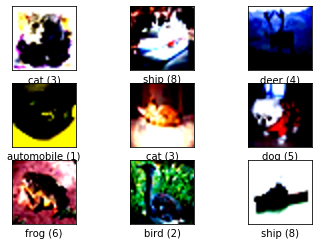

In [22]:
train_loader, valid_loader = get_train_valid_loader('./data',
                                                    batch_size=2,
                                                    random_seed=123,
                                                    valid_ratio=0.1,
                                                    shuffle=True,
                                                    show_sample=True,
                                                    num_workers=0)

In [23]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=0):
    """
    Utility function for loading and returning a multi-process
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    
    Returns
    -------
    - data_loader: test set iterator.
    """
    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, 
        shuffle=shuffle, num_workers=num_workers
    )

    return data_loader

In [24]:
test_loader = get_test_loader(data_dir='./data',
                              batch_size=2,
                              shuffle=False,
                              num_workers=4)

Files already downloaded and verified


# Trainer

In [25]:
import os 

In [26]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [34]:
class Trainer(object):
    def __init__(self, args):
        self.device  = args.device
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.criterion = nn.CrossEntropyLoss()
                
        self.epochs = args.epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=args.lr)
        self.train_loader = args.train_loader
        self.valid_loader = args.valid_loader
    
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path
        
    def train(self):
        print('Start training ...')
        
        best_loss = 1.e10
        for epoch in range(self.epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader):
                inputs, labels = data
            
                self.optimizer.zero_grad()
            
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            
                running_loss += loss.item()
                if (i+1) % 2000 == 0:
                    print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000: .3f}")
                    running_loss = 0.0   
                    
                valid_loss = self.valid()
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {'epoch': epoch, 
                        'state_dict': self.model.state_dict(),
                        'best_loss': best_loss}
                save_model(state, is_best, save_dir=self.model_path)                   
        print('Finished training ...')
        
    def valid(self):
        self.model.eval()
        valid_loss = 0.0
        for i, data in enumerate(self.valid_loader):
            inputs, labels = data
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            valid_loss += loss.item()
        return valid_loss

# Options

In [35]:
import argparse

In [36]:
class Options(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs', type=int, default=10, help='epochs for optimizer')
        
        self.parser = parser
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return arg

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


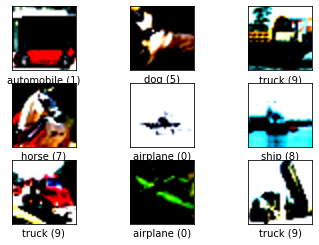

In [39]:
args = Options().parse()
args.train_loader, args.valid_loader = get_train_valid_loader('./data',
                                                    batch_size=2,
                                                    random_seed=123,
                                                    valid_ratio=0.1,
                                                    shuffle=True,
                                                    show_sample=True,
                                                    num_workers=0)

In [40]:
args.model = ResNet(ResidualBlock, 10)
trainer = Trainer(args)

In [41]:
print(args)

Namespace(cuda=True, device=device(type='cuda'), epochs=10, lr=0.001, model=ResNet with ResidualBlock, no_cuda=False, train_loader=<torch.utils.data.dataloader.DataLoader object at 0x000001A3842F14A8>, valid_loader=<torch.utils.data.dataloader.DataLoader object at 0x000001A3842F1320>)


In [ ]:
trainer.train()